In [1]:
from bertopic import BERTopic
from umap import UMAP
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
import scispacy
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"]    = "1"

# data preparation
proc = pd.read_csv("../data/D_ICD_PROCEDURES.csv", usecols=["ICD9_CODE","LONG_TITLE"])
proc['ICD9_CODE'] = proc['ICD9_CODE'].astype(str).str.zfill(4)
# BASIC CLEANING
proc['text'] = (
    proc['LONG_TITLE']
        .str.lower()
        .str.replace(r'[^a-z0-9\s]', ' ', regex=True)   # keep alphanum
        .str.replace(r'\s+', ' ', regex=True)           # collapse spaces
        .str.strip()
)
texts = proc['text'].tolist()

# fit BERTopic
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    metric="cosine",
    random_state=42,
    n_jobs=1,          # <-- force single-process
    verbose=True
)

topic_model = BERTopic(
    embedding_model=embedder,
    umap_model=umap_model,       # <-- here!
    min_topic_size=20,
    n_gram_range=(1, 2),
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts)


/Users/yixinshen/miniforge3/envs/mednlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 16:35:46,869 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|████████████████████████████████| 122/122 [00:01<00:00, 77.65it/s]
2025-07-07 16:35:48,461 - BERTopic - Embedding - Completed ✓
2025-07-07 16:35:48,462 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(angular_rp_forest=True, metric='cosine', n_components=5, n_jobs=1, random_state=42, verbose=True)
Mon Jul  7 16:35:48 2025 Construct fuzzy simplicial set
Mon Jul  7 16:35:54 2025 Finding Nearest Neighbors
Mon Jul  7 16:35:56 2025 Finished Nearest Neighbor Search
Mon Jul  7 16:35:57 2025 Construct embedding


Epochs completed:   4%| █▋                                        20/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  14%| █████▊                                    71/500 [00:00]

	completed  50  /  500 epochs


Epochs completed:  24%| █████████▌                               120/500 [00:00]

	completed  100  /  500 epochs


Epochs completed:  34%| █████████████▌                           170/500 [00:01]

	completed  150  /  500 epochs


Epochs completed:  44%| █████████████████▋                       221/500 [00:01]

	completed  200  /  500 epochs


Epochs completed:  54%| █████████████████████▊                   272/500 [00:01]

	completed  250  /  500 epochs


Epochs completed:  65%| █████████████████████████▊               323/500 [00:02]

	completed  300  /  500 epochs


Epochs completed:  75%| █████████████████████████████▉           374/500 [00:02]

	completed  350  /  500 epochs


Epochs completed:  85%| █████████████████████████████████▉       424/500 [00:02]

	completed  400  /  500 epochs


Epochs completed:  94%| █████████████████████████████████████▊   472/500 [00:03]

	completed  450  /  500 epochs


Epochs completed: 100%| ████████████████████████████████████████ 500/500 [00:03]
2025-07-07 16:36:00,402 - BERTopic - Dimensionality - Completed ✓
2025-07-07 16:36:00,402 - BERTopic - Cluster - Start clustering the reduced embeddings


Mon Jul  7 16:36:00 2025 Finished embedding


2025-07-07 16:36:00,626 - BERTopic - Cluster - Completed ✓
2025-07-07 16:36:00,630 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-07 16:36:00,666 - BERTopic - Representation - Completed ✓


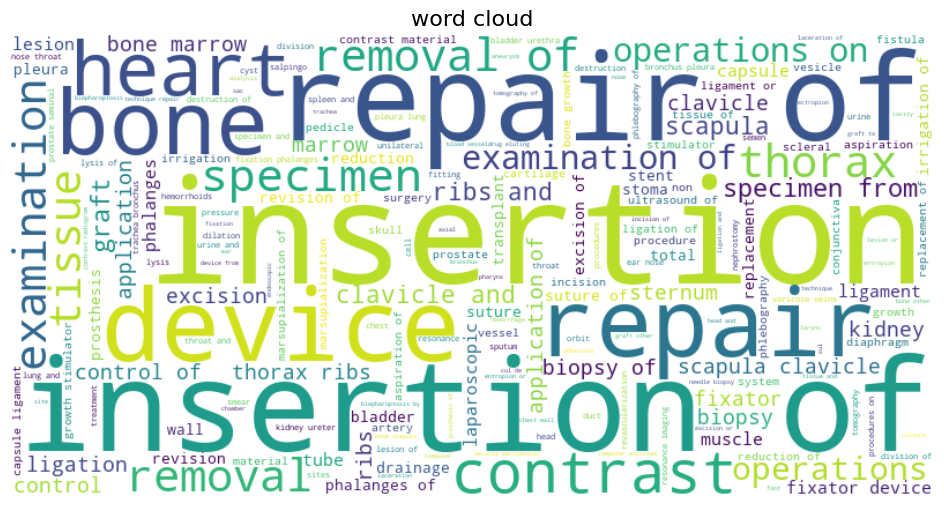

Topic  0: ovary, uterus, of ovary, vaginal, of uterus, cervix, spermatic, vas deferens, deferens, spermatic cord
Topic  1: joint, of joint, hip, dislocation, knee, dislocation of, of dislocation, arthrotomy, replacement, amputation
Topic  2: eyelid, of eyelid, retinal, of retinal, by, lens, eyeball, cornea, photocoagulation, corneal
Topic  3: microscopic, microscopic examination, examination, examination of, of specimen, specimen from, specimen, from, and of, culture
Topic  4: bone, of bone, on bone, fibula, and fibula, tibia, tibia and, patella, ostectomy, radius and
Topic  5: bladder, of bladder, urethra, ureter, prostate, transurethral, of urethra, of prostate, prostatectomy, urethral
Topic  6: lung, of lung, larynx, bronchus, trachea, of bronchus, lung other, tracheostomy, of larynx, or
Topic  7: cardiac, pacemaker, intravascular, implantation, monitoring, intravascular imaging, of cardiac, defibrillator, replacement, lead
Topic  8: intestine, large intestine, large, of large, smal

In [2]:
# class based TF IDF
vectorizer = topic_model.vectorizer_model
counts     = vectorizer.transform(texts)             # shape: (n_docs, n_terms)

# 4) Compute class-based TF–IDF
c_tf_idf = topic_model.c_tf_idf_
terms = topic_model.vectorizer_model.get_feature_names_out()

# wod cloud
topic_idx = 0
row       = c_tf_idf[topic_idx].toarray().flatten()
freqs     = {term: w for term, w in zip(terms, row)}
# specify nouns
nlp = spacy.load("en_core_web_sm")
weighted_freqs = {}
for term, weight in freqs.items():
    # spaCy will tokenize your single-word term and tag it
    token = nlp(term)[0]
    if token.pos_ in ("NOUN", "PROPN"):
        # boost noun weight (e.g. ×2)
        weighted_freqs[term] = weight * 2.0
    else:
        # optionally down-weight or zero out everything else
        weighted_freqs[term] = weight * 0.1
wc = WordCloud(
    width=800, height=400,
    background_color="white",
    max_words=200,
    relative_scaling=0.5,
).generate_from_frequencies(weighted_freqs)

fig = plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("word cloud", fontsize=16)
fig.savefig("wordcloud_topic0.png", dpi=300, bbox_inches="tight")

plt.show()

# 6) Extract top N keywords per topic
top_n = 10
keywords = {}
for topic_idx in topic_model.get_topic_info().Topic.tolist():
    if topic_idx == -1:
        continue
    # c_tf_idf[topic_idx] is a sparse row; convert to dense array
    row = c_tf_idf[topic_idx].toarray().flatten()
    top_indices = row.argsort()[::-1][:top_n]
    keywords[topic_idx] = [term for term, _ in topic_model.get_topic(topic_idx)[:top_n]]

# 7) Display
for t, words in keywords.items():
    print(f"Topic {t:>2}: {', '.join(words)}")


In [3]:
proc['topic'] = topics
print(topic_model.get_topic_info().head(15))

# map topics to admissions
events = pd.read_csv(
    "../data/PROCEDURES_ICD.csv",
    usecols=["HADM_ID", "ICD9_CODE"]
)
events["ICD9_CODE"] = events["ICD9_CODE"].astype(str).str.zfill(4)
events = events.merge(
    proc[["ICD9_CODE", "topic"]],
    on="ICD9_CODE",
    how="left"
)
# drop outliers
events = events[events["topic"] != -1]
# ------------------------------------------------------------------
# 3A.  COUNT version  (how many procedures in each topic per admission)
topic_counts = (
    events
      .groupby(["HADM_ID", "topic"])
      .size()
      .unstack(fill_value=0)
      .add_prefix("proc_topic_")
      .reset_index()
)

# 3B.  BINARY version  (1 if any procedure of that topic appears)
topic_flags = topic_counts.copy()
topic_flags.iloc[:, 1:] = (topic_flags.iloc[:, 1:] > 0).astype(int)

# save whichever version you need
topic_counts.to_csv("proc_topic_counts.csv", index=False)
topic_flags.to_csv("proc_topic_flags.csv", index=False)

print("wrote", topic_counts.shape[0], "rows ×", topic_counts.shape[1]-1, "topic cols")



    Topic  Count                                               Name  \
0      -1   1114                          -1_of_and_other_insertion   
1       0    202                    0_ovary_uterus_of ovary_vaginal   
2       1    194                   1_joint_of joint_hip_dislocation   
3       2    155              2_eyelid_of eyelid_retinal_of retinal   
4       3    122  3_microscopic_microscopic examination_examinat...   
5       4    120                      4_bone_of bone_on bone_fibula   
6       5    111                5_bladder_of bladder_urethra_ureter   
7       6     99                     6_lung_of lung_larynx_bronchus   
8       7     97     7_cardiac_pacemaker_intravascular_implantation   
9       8     86         8_intestine_large intestine_large_of large   
10      9     84                 9_duct_anastomosis_pancreatic_bile   
11     10     83             10_vessels_vessel_of vessel_of vessels   
12     11     82                 11_nerve_cranial_peripheral_nerves   
13    